In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import FinanceDataReader as fdr

In [3]:
import plotly.express as px
import plotly.graph_objects as go

In [16]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df/df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)
    
def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()

### 연단위 

In [17]:
def get_annualized_returns_series(log_return_df, num_day_in_year=250):
    return (log_return_df.mean() * num_day_in_year).round(2)

def get_annualized_std_series(log_return_df, num_day_in_year=250):
    return (log_return_df.std() * (num_day_in_year ** 0.5)).round(2)

In [18]:
def get_cagr_series(cum_rtn_df, num_day_in_year = 250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

In [19]:
def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

In [20]:
def get_drawdown_infos(cum_returns_df):
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df -1
    
    mdd_series = dd_df.min()
    
    max_point_df = dd_df[dd_df == 0]
    
    first_df = max_point_df.index[:-1]
    second_df = max_point_df.index[1:]
    
    period = first_df - second_df
    
    longest_dd_period = period.min().days
    
    ldd_st = first_df[period.argmin()]
    ldd_ed = second_df[period.argmin()]
    
    return mdd_series, longest_dd_period, ldd_st, ldd_ed

## 이동평균선

In [58]:
df = fdr.DataReader('011200', '2020')

In [59]:
df['sma'] = df['Close'].rolling(5).mean()
df['lma'] = df['Close'].rolling(20).mean()
df.head()

,Open,High,Low,Close,Volume,Change,sma,lma
Date,,,,,,,,
2020-01-02,3555,3770,3555,3750,1799891,0.056338,NaN,NaN
2020-01-03,3765,3865,3745,3775,1567072,0.006667,NaN,NaN
2020-01-06,3725,3840,3660,3835,1312388,0.015894,NaN,NaN
2020-01-07,3840,3920,3810,3900,1300247,0.016949,NaN,NaN
2020-01-08,3845,3960,3740,3765,1745074,-0.034615,3805.0,NaN


In [60]:
df.dropna(inplace=True)

In [61]:
df['position'] = np.where(df['sma'] >= df['lma'], 1, 0)

In [62]:
long_index = df[(df['position'] - df['position'].shift(1)) == 1].index
exit_index = df[(df['position'] - df['position'].shift(1)) == -1].index

<AxesSubplot:xlabel='Date'>

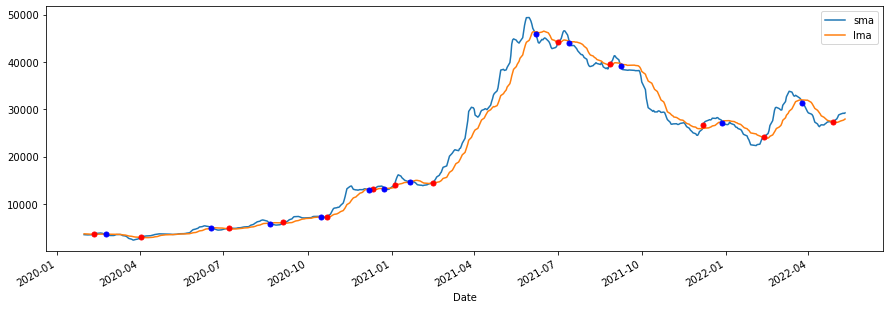

In [63]:
df[['sma','lma']].plot(figsize=(15,5))
df.loc[long_index, 'sma'].plot(marker='o', color='red', linestyle='none', markersize=5)
df.loc[exit_index, 'sma'].plot(marker='o', color='blue', linestyle='none', markersize=5)

In [64]:
df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn
Date,,,,,,,,,,
2020-01-31,3455,3525,3455,3475,639462,-0.007143,3517.0,3695.75,0,0.000000
2020-02-03,3435,3435,3340,3400,1032561,-0.021583,3470.0,3678.25,0,-0.021819
2020-02-04,3400,3530,3400,3475,574954,0.022059,3470.0,3663.25,0,0.021819
2020-02-05,3530,3545,3490,3520,396345,0.012950,3474.0,3647.50,0,0.012867
2020-02-06,3520,3580,3520,3530,582315,0.002841,3480.0,3629.00,0,0.002837
...,...,...,...,...,...,...,...,...,...,...
2022-05-04,29350,29400,28300,29200,2661654,0.010381,28790.0,27335.00,1,0.010327
2022-05-06,28750,29600,28550,29450,3151619,0.008562,28980.0,27517.50,1,0.008525
2022-05-09,29250,29400,28750,29400,2438194,-0.001698,29180.0,27690.00,1,-0.001699


In [65]:
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

In [66]:
df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn,str_rtn,cum_str_rtn
Date,,,,,,,,,,,,
2020-01-31,3455,3525,3455,3475,639462,-0.007143,3517.0,3695.75,0,0.000000,0.000000,1.000000
2020-02-03,3435,3435,3340,3400,1032561,-0.021583,3470.0,3678.25,0,-0.021819,-0.000000,1.000000
2020-02-04,3400,3530,3400,3475,574954,0.022059,3470.0,3663.25,0,0.021819,0.000000,1.000000
2020-02-05,3530,3545,3490,3520,396345,0.012950,3474.0,3647.50,0,0.012867,0.000000,1.000000
2020-02-06,3520,3580,3520,3530,582315,0.002841,3480.0,3629.00,0,0.002837,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,29350,29400,28300,29200,2661654,0.010381,28790.0,27335.00,1,0.010327,0.010327,6.233465
2022-05-06,28750,29600,28550,29450,3151619,0.008562,28980.0,27517.50,1,0.008525,0.008525,6.286833
2022-05-09,29250,29400,28750,29400,2438194,-0.001698,29180.0,27690.00,1,-0.001699,-0.001699,6.276160


In [70]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [72]:
print('cagr :', cagr)
print('sharp_ratio :', sharp_ratio)
print('Max_drawdown :', mdd)
print('Longest_dd_period :', ldd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr : 1.2606921683016856
sharp_ratio : 1.716825821168096
Max_drawdown : -0.3247804833107112
Longest_dd_period : -281
Longest_dd_st_date : 2021-05-27 00:00:00
Longest_dd_ed_date : 2022-03-04 00:00:00


<AxesSubplot:xlabel='Date'>

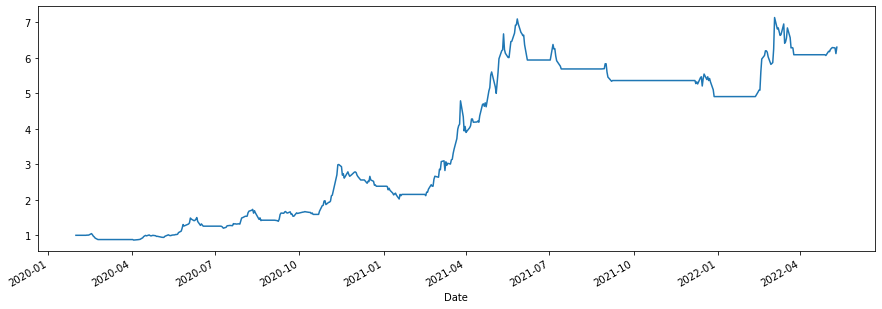

In [69]:
df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

# Momentum

In [73]:
df = fdr.DataReader('011200', '2020')

In [74]:
momentum_window=20*3

In [75]:
get_returns_df(df['Close'], N=momentum_window)

Date
2020-03-27    0.000000
2020-03-30   -0.252000
2020-03-31   -0.178808
2020-04-01   -0.178618
2020-04-02   -0.161538
                ...   
2022-05-04    0.258621
2022-05-06    0.206967
2022-05-09    0.202454
2022-05-10    0.162272
2022-05-11    0.207392
Name: Close, Length: 524, dtype: float64

In [76]:
position = np.sign(get_returns_df(df['Close'], N=momentum_window))
position.head()

Date
2020-03-27    0.0
2020-03-30   -1.0
2020-03-31   -1.0
2020-04-01   -1.0
2020-04-02   -1.0
Name: Close, dtype: float64

In [77]:
position.value_counts()

 1.0    366
-1.0    156
 0.0      2
Name: Close, dtype: int64

In [78]:
position[position == -1] = 0

In [79]:
position.value_counts()

1.0    366
0.0    158
Name: Close, dtype: int64

In [80]:
df.loc[:, 'position'] = position

In [81]:
df.dropna(inplace=True)

In [82]:
long_index = df[(df['position'] - df['position'].shift(1)) == 1].index
exit_index = df[(df['position'] - df['position'].shift(1)) == -1].index

<AxesSubplot:xlabel='Date'>

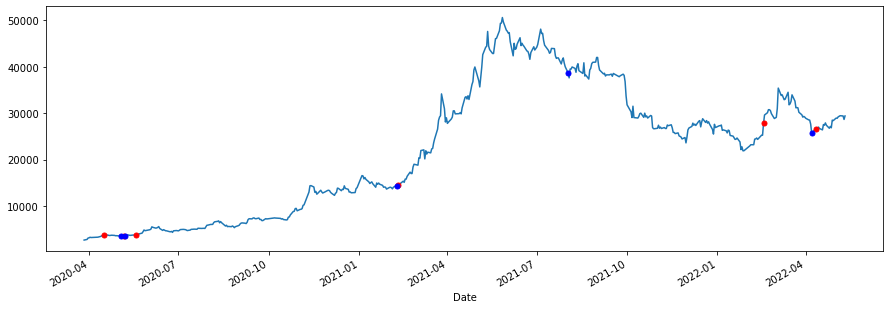

In [83]:
ax = df.loc[:, 'Close'].loc['2018-01-01':].plot(figsize=(15,5))

df.loc[long_index, 'Close'].plot(ax=ax, marker='o', color='red', linestyle='none', markersize=5)
df.loc[exit_index, 'Close'].plot(ax=ax, marker='o', color='blue', linestyle='none', markersize=5)

In [84]:
df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)

In [85]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [86]:
print('cagr :', cagr)
print('sharp_ratio :', sharp_ratio)
print('Max_drawdown :', mdd)
print('Longest_dd_period :', ldd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr : 1.9867024926163044
sharp_ratio : 2.1057726068209486
Max_drawdown : -0.2951230761890118
Longest_dd_period : -52
Longest_dd_st_date : 2020-11-13 00:00:00
Longest_dd_ed_date : 2021-01-04 00:00:00


<AxesSubplot:xlabel='Date'>

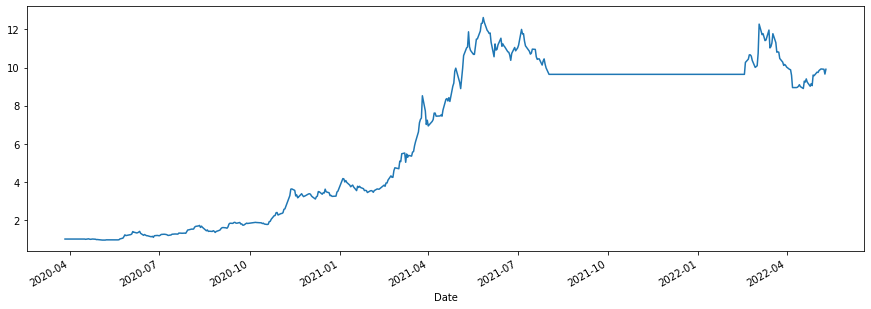

In [87]:
df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

In [89]:
# 모멘텀 전략 함수 

def momentum(df, mw):
    
    momentum_window=mw
    
    position = np.sign(get_returns_df(df['Close'], N=momentum_window))
    position[position == -1] = 0
    
    df.loc[:, 'position'] = position
    df.dropna(inplace=True)
    
    df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
    df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

    df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
    
    cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])
    
    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)
    
    df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

cagr : 1.9867024926163044
sharp_ratio : 2.1057726068209486
Max_drawdown : -0.2951230761890118
Longest_dd_period : -52
Longest_dd_st_date : 2020-11-13 00:00:00
Longest_dd_ed_date : 2021-01-04 00:00:00


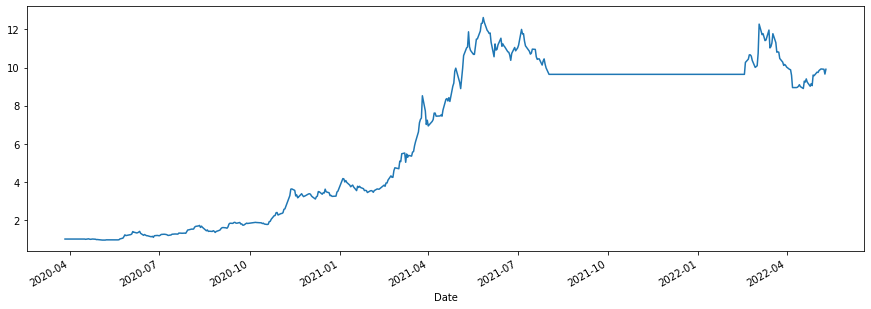

In [90]:
df = fdr.DataReader('011200', '2020')
mw = 60

momentum(df, mw)

# Mean-Reversion

In [91]:
df = fdr.DataReader('011200', '2020')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,3555,3770,3555,3750,1799891,0.056338
2020-01-03,3765,3865,3745,3775,1567072,0.006667
2020-01-06,3725,3840,3660,3835,1312388,0.015894
2020-01-07,3840,3920,3810,3900,1300247,0.016949
2020-01-08,3845,3960,3740,3765,1745074,-0.034615


In [92]:
df = df[['Close']]
df

,Close
Date,
2020-01-02,3750
2020-01-03,3775
2020-01-06,3835
2020-01-07,3900
2020-01-08,3765
...,...
2022-05-04,29200
2022-05-06,29450
2022-05-09,29400


In [93]:
window = 20
df.loc[:, 'sma'] = df['Close'].rolling(window).mean()

In [94]:
rolling_std = df['Close'].rolling(window).std()

In [95]:
df.dropna(inplace=True)

In [97]:
df['+threshold'] = df['sma'] + 2*rolling_std
df['-threshold'] = df['sma'] - 2*rolling_std

<AxesSubplot:xlabel='Date'>

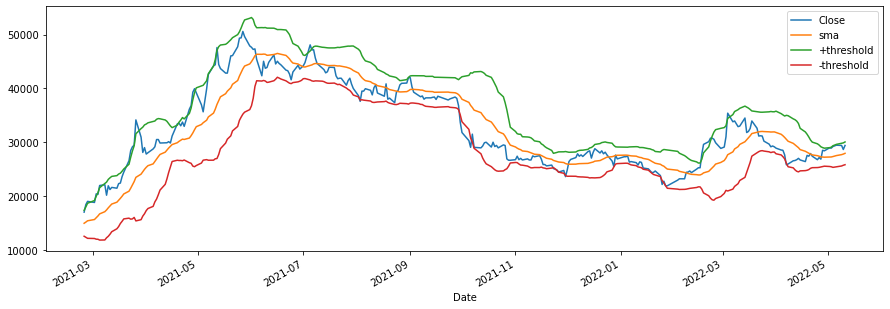

In [98]:
df[['Close', 'sma', '+threshold', '-threshold']].iloc[-300:].plot(figsize=(15,5))

In [99]:
pos1 = np.where(df['Close'] <= df['-threshold'], 1, 0)
pos2 = np.where(df['Close'] >= df['+threshold'], -1, 0)

df.loc[:, 'position'] = pos1 + pos2

In [100]:
short_index = df[
    ((df['position'] - df['position'].shift()) == -1) & (df['position'] == -1)
].index

short_index

DatetimeIndex(['2020-02-17', '2020-05-22', '2020-06-04', '2020-07-29',
               '2020-08-06', '2020-09-10', '2020-10-23', '2020-11-09',
               '2020-12-17', '2021-01-04', '2021-02-15', '2021-02-17',
               '2021-02-25', '2021-03-03', '2021-03-05', '2021-03-22',
               '2021-04-19', '2021-04-26', '2021-05-10', '2021-05-12',
               '2021-07-05', '2022-02-17', '2022-03-04'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [101]:
long_index = df[
    ((df['position'] - df['position'].shift()) ==1) & (df['position'] == 1)
].index

long_index

DatetimeIndex(['2020-03-16', '2020-03-18', '2021-08-03', '2021-09-30',
               '2021-11-23', '2021-11-30', '2022-01-25', '2022-01-27',
               '2022-04-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

<AxesSubplot:xlabel='Date'>

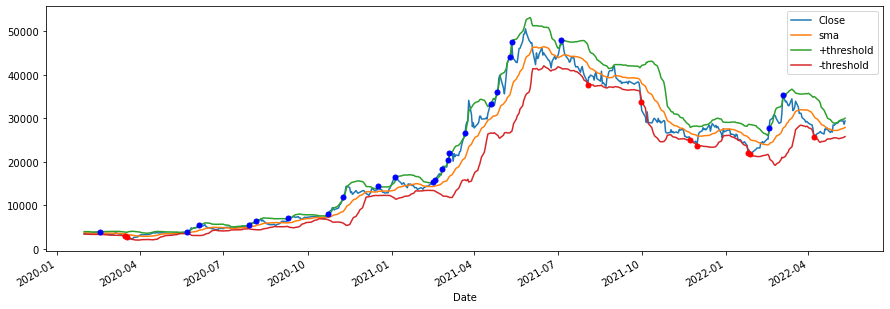

In [102]:
ax = df[['Close', 'sma', '+threshold', '-threshold']].plot(figsize=(15,5))
df.loc[short_index, 'Close'].plot(ax=ax, marker='o', markersize=5, linestyle='none', color='blue')
df.loc[long_index, 'Close'].plot(ax=ax, marker='o', markersize=5, linestyle='none', color='red')

In [103]:
df['rtn'] = get_returns_df(df['Close'], log=True)
df['str_rtn'] = (df['position'].shift() * df['rtn']).fillna(0)

In [104]:
df.loc[:, 'cum_rtn'] = get_cum_returns_df(df['rtn'], log=True)
df.loc[:, 'str_cum_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)

<AxesSubplot:xlabel='Date'>

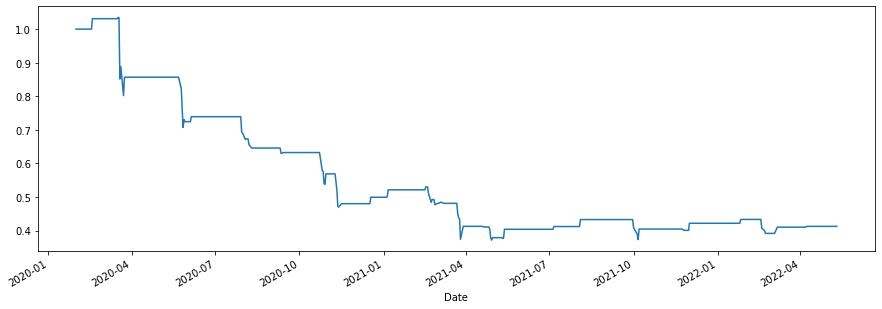

In [105]:
df['str_cum_rtn'].plot(figsize=(15,5))

In [106]:
def backtest_eval(scr, sr):

    cagr = get_cagr_series(df[scr], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df[sr], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df[scr])

    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)

In [107]:
cr = 'str_cum_rtn'
sr = 'str_rtn'

backtest_eval(cr, sr)

cagr : -0.32445568660168045
sharp_ratio : -1.449308563649617
Max_drawdown : -0.6404857386272115
Longest_dd_period : -3
Longest_dd_st_date : 2020-01-31 00:00:00
Longest_dd_ed_date : 2020-02-03 00:00:00


## 변동성 돌파 전략

In [108]:
df = fdr.DataReader('011200', '2020')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,3555,3770,3555,3750,1799891,0.056338
2020-01-03,3765,3865,3745,3775,1567072,0.006667
2020-01-06,3725,3840,3660,3835,1312388,0.015894
2020-01-07,3840,3920,3810,3900,1300247,0.016949
2020-01-08,3845,3960,3740,3765,1745074,-0.034615


In [109]:
df = df[['Open', 'High', 'Close', 'Low']]

In [110]:
df['range'] = df['High'] - df['Low']
df['threshold'] = df['Open'] + df['range'].shift()*0.6
df.head()

,Open,High,Close,Low,range,threshold
Date,,,,,,
2020-01-02,3555,3770,3750,3555,215,NaN
2020-01-03,3765,3865,3775,3745,120,3894.0
2020-01-06,3725,3840,3835,3660,180,3797.0
2020-01-07,3840,3920,3900,3810,110,3948.0
2020-01-08,3845,3960,3765,3740,220,3911.0


In [111]:
df.dropna(inplace=True)

In [112]:
cond = df['threshold'] <= df['High']
df['position'] = cond.astype(int)

In [113]:
df

,Open,High,Close,Low,range,threshold,position
Date,,,,,,,
2020-01-03,3765,3865,3775,3745,120,3894.0,0
2020-01-06,3725,3840,3835,3660,180,3797.0,1
2020-01-07,3840,3920,3900,3810,110,3948.0,0
2020-01-08,3845,3960,3765,3740,220,3911.0,1
2020-01-09,3900,3910,3850,3800,110,4032.0,0
...,...,...,...,...,...,...,...
2022-05-04,29350,29400,29200,28300,1100,29710.0,0
2022-05-06,28750,29600,29450,28550,1050,29410.0,1
2022-05-09,29250,29400,29400,28750,650,29880.0,0


In [114]:
p_current = df['Open']
p_prev = df['threshold'].shift()
df['rtn'] = p_current/ p_prev -1

In [115]:
df

,Open,High,Close,Low,range,threshold,position,rtn
Date,,,,,,,,
2020-01-03,3765,3865,3775,3745,120,3894.0,0,NaN
2020-01-06,3725,3840,3835,3660,180,3797.0,1,-0.043400
2020-01-07,3840,3920,3900,3810,110,3948.0,0,0.011325
2020-01-08,3845,3960,3765,3740,220,3911.0,1,-0.026089
2020-01-09,3900,3910,3850,3800,110,4032.0,0,-0.002813
...,...,...,...,...,...,...,...,...
2022-05-04,29350,29400,29200,28300,1100,29710.0,0,-0.022644
2022-05-06,28750,29600,29450,28550,1050,29410.0,1,-0.032312
2022-05-09,29250,29400,29400,28750,650,29880.0,0,-0.005440


In [116]:
df['str_rtn'] = df['position'].shift() * df['rtn']
df['str_rtn'] = df['str_rtn'].fillna(0)

In [117]:
df.loc[:, 'str_cum_rtn'] = get_cum_returns_df(df['str_rtn'], log=False)

<AxesSubplot:xlabel='Date'>

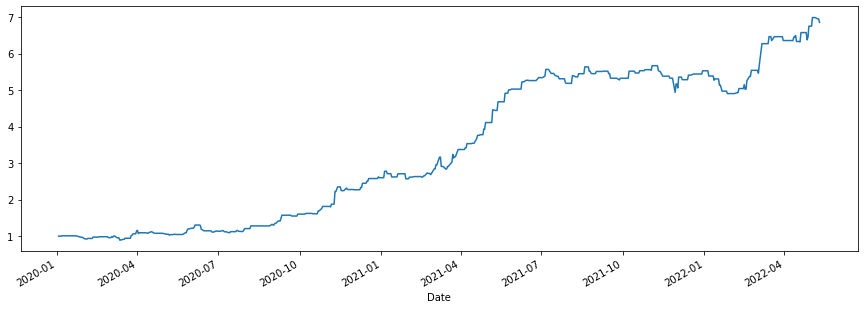

In [118]:
df['str_cum_rtn'].plot(figsize=(15,5))

In [119]:
def backtest_eval(scr, sr):

    cagr = get_cagr_series(df[scr], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df[sr], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df[scr])

    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)

In [120]:
cr = 'str_cum_rtn'
sr = 'str_rtn'

backtest_eval(cr, sr)

cagr : 1.2864162766583433
sharp_ratio : 2.6720473487010463
Max_drawdown : -0.1626627753003409
Longest_dd_period : -115
Longest_dd_st_date : 2021-11-09 00:00:00
Longest_dd_ed_date : 2022-03-04 00:00:00
